In [1]:
%%capture
!pip install deepchem transformers peft

In [3]:
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("deepchem").setLevel(logging.ERROR)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import deepchem as dc
from peft import get_peft_model, LoraConfig, TaskType, AdaLoraConfig
import time
from sklearn.metrics import accuracy_score
from rdkit import Chem
import wandb
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Define paths and parameters
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5

# LoRA Configuration
LORA_R = 8  # Rank of LoRA
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

In [6]:
class ClinToxDataset(Dataset):
    def __init__(self, data_path, tokenizer, split='train', max_length=128):
        """
        Custom PyTorch Dataset for the ClinTox dataset.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split

        # Load ClinTox dataset from DeepChem
        tasks, datasets, transformers = dc.molnet.load_clintox()
        train_dataset, valid_dataset, test_dataset = datasets

        # Convert to SMILES and labels
        self.smiles_train, self.labels_train = self.remove_invalid_smiles(train_dataset.ids, train_dataset.y)
        self.smiles_valid, self.labels_valid = self.remove_invalid_smiles(valid_dataset.ids, valid_dataset.y)
        self.smiles_test, self.labels_test = self.remove_invalid_smiles(test_dataset.ids, test_dataset.y)

        # Set active data split based on input parameter
        if split == 'train':
            self.smiles = self.smiles_train
            self.labels = self.labels_train
        elif split == 'valid':
            self.smiles = self.smiles_valid
            self.labels = self.labels_valid
        elif split == 'test':
            self.smiles = self.smiles_test
            self.labels = self.labels_test
        else:
            raise ValueError("Invalid split. Use 'train', 'valid', or 'test'.")

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            smiles,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

    def remove_invalid_smiles(self, smiles, labels):
        """
        Filters out invalid SMILES strings using RDKit validation.
        """
        valid_indices = []
        for i, smile in enumerate(smiles):
            try:
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    valid_indices.append(i)
            except:
                pass

        return smiles[valid_indices], labels[valid_indices]

In [7]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on the validation or test set.
    """
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)

            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Binary predictions for accuracy
    bin_preds = (all_preds > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, bin_preds)

    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [8]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    percentage_trained = round(100*trainable_params/all_params, 2)
    print(f"Trainable: {trainable_params} | All: {all_params} | % Trained: {percentage_trained}")
    return trainable_params, all_params, percentage_trained

In [9]:
def train_and_profile(model, tokenizer, optimization_name, lr=LEARNING_RATE):
    """
    Training Loop with Profiling
    """

    print(f"\n--- {optimization_name} - Trainable Parameters ---")
    trainable_params, all_params, percentage_trained = print_trainable_parameters(model)

    # Create datasets for each split
    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)
    val_dataset = ClinToxDataset("clintox", tokenizer, split="valid", max_length=MAX_LENGTH)
    test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses, val_accuracies = [], [], []

    print(f"\n--- {optimization_name} ---")

    # Start timing
    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        epoch_time = time.time() - epoch_start_time

        avg_train_loss = total_train_loss / len(train_dataloader)
        val_loss, val_acc = evaluate_model(model, val_dataloader, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1} | Training Time: {epoch_time:.2f} s | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    end_time = time.time()

    test_loss, test_acc = evaluate_model(model, test_dataloader, device)
    training_time = round(end_time - start_time, 2)
    print(f"\n--- {optimization_name} ---")
    print(f"Training time: {training_time} seconds")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "training_time": training_time,
        "test_accuracy": test_acc}

In [10]:
def hyperparameter_tuning(model_type="LoRA", learning_rates=[1e-5, 2e-5, 3e-5, 5e-5, 1e-4, 3e-4]):
    """
    Run hyperparameter tuning  with wandb tracking
    """

    # Initialize the main sweep run
    #main_run = wandb.init(project="testing", name="LoRA_Hyperparameter_Sweep")

    results = {
        "learning_rate": [],
        "test_accuracy": [],
        "training_time": [],
    }

    # Run experiment for each learning rate
    for lr in learning_rates:
        print(f"\n--- {model_type} with learning_rate={lr} ---")

        # new model for each run
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        model = None

        if model_type.lower() == "lora":
          model = setup_lora_model(MODEL_NAME)
        elif model_type.lower() == "adalora":
          model = setup_adalora_model(MODEL_NAME)

        metrics = train_and_profile(model, tokenizer, f"{model_type}_lr_{lr}", lr=lr)

        results["learning_rate"].append(lr)
        results["test_accuracy"].append(metrics["test_accuracy"])
        results["training_time"].append(metrics["training_time"])

        # Clean up memory
        del model, tokenizer
        torch.cuda.empty_cache()

    # Create results dataframe
    results_df = pd.DataFrame(results)

    # Create and log summary visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(results_df["learning_rate"], results_df["test_accuracy"], 'bo-')
    ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(f'{model_type} Performance vs Learning Rate')
    ax.grid(True)

    # Add text annotations for each point
    for i, lr in enumerate(results_df["learning_rate"]):
        ax.annotate(
            f"Time: {results_df['training_time'][i]:.1f}s\nAcc: {results_df['test_accuracy'][i]:.4f}",
            (lr, results_df["test_accuracy"][i]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )

    '''
    # Log the figure to wandb
    wandb.log({"lora_hyperparameter_results": wandb.Image(fig)})

    # Log the results as a table
    results_table = wandb.Table(dataframe=results_df)
    wandb.log({"lora_hyperparameter_table": results_table})

    wandb.finish()
    '''
    return results_df


## Base ChemBeRTa Model Without Any Additional Fine-Tuning

In [11]:
baseline = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline.to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


_, test_acc = evaluate_model(baseline, test_dataloader, device)

print(f"Baseline (Not Fine-Tuned) Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

Baseline (Not Fine-Tuned) Test Accuracy: 0.0541


## Base ChemBeRTa Model with Full Parameter Fine-Tuning


In [12]:
def setup_baseline_model(model_name):
    """
    Set up a baseline model
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )
    return model

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_baseline = setup_baseline_model(MODEL_NAME)

train_and_profile(model_baseline, tokenizer, "Model Baseline Finetuned")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Model Baseline Finetuned - Trainable Parameters ---
Trainable: 44105474 | All: 44105474 | % Trained: 100.0

--- Model Baseline Finetuned ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.07it/s]


Epoch 1 | Training Time: 5.39 s | Train Loss: 0.2420 | Val Loss: 0.0948 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 21.02it/s]


Epoch 2 | Training Time: 5.38 s | Train Loss: 0.0845 | Val Loss: 0.0812 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.58it/s]


Epoch 3 | Training Time: 5.42 s | Train Loss: 0.0553 | Val Loss: 0.1413 | Val Accuracy: 0.9324


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.93it/s]


Epoch 4 | Training Time: 5.42 s | Train Loss: 0.0376 | Val Loss: 0.0783 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.77it/s]


Epoch 5 | Training Time: 5.46 s | Train Loss: 0.0364 | Val Loss: 0.0801 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.72it/s]


--- Model Baseline Finetuned ---
Training time: 28.28 seconds
Test Loss: 0.0555 | Test Accuracy: 0.9797


{'train_losses': [0.24199659075285937,
  0.08449434423567476,
  0.05528226980587115,
  0.037612939152765916,
  0.03635694129342163],
 'val_losses': [0.094773680716753,
  0.08120690062642097,
  0.1413046343252063,
  0.07825353220105172,
  0.08013407383114099],
 'val_accuracies': [0.9797297297297297,
  0.972972972972973,
  0.9324324324324325,
  0.9797297297297297,
  0.9797297297297297],
 'training_time': 28.28,
 'test_accuracy': 0.9797297297297297}

## ChemBeRTa With LoRA Fine-Tuning

In [14]:
def setup_lora_model(model_name):
    """
    Set up a model with LoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=["query", "value"]  # Target attention modules
    )

    model = get_peft_model(model, peft_config)
    return model


--- LoRA with learning_rate=1e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_1e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65

--- LoRA_lr_1e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.55it/s]


Epoch 1 | Training Time: 3.92 s | Train Loss: 0.5384 | Val Loss: 0.3498 | Val Accuracy: 0.9459


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.20it/s]


Epoch 2 | Training Time: 3.92 s | Train Loss: 0.3386 | Val Loss: 0.2372 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Epoch 3 | Training Time: 3.94 s | Train Loss: 0.2757 | Val Loss: 0.2017 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.45it/s]


Epoch 4 | Training Time: 3.97 s | Train Loss: 0.2444 | Val Loss: 0.1846 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


Epoch 5 | Training Time: 3.98 s | Train Loss: 0.2294 | Val Loss: 0.1746 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]



--- LoRA_lr_1e-05 ---
Training time: 21.02 seconds
Test Loss: 0.1808 | Test Accuracy: 0.9324

--- LoRA with learning_rate=2e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_2e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65

--- LoRA_lr_2e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.51it/s]


Epoch 1 | Training Time: 3.94 s | Train Loss: 0.4213 | Val Loss: 0.2153 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.25it/s]


Epoch 2 | Training Time: 3.93 s | Train Loss: 0.2487 | Val Loss: 0.1767 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.92it/s]


Epoch 3 | Training Time: 3.89 s | Train Loss: 0.2163 | Val Loss: 0.1620 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.14it/s]


Epoch 4 | Training Time: 3.89 s | Train Loss: 0.1848 | Val Loss: 0.1472 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.09it/s]


Epoch 5 | Training Time: 3.88 s | Train Loss: 0.1628 | Val Loss: 0.1302 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.11it/s]



--- LoRA_lr_2e-05 ---
Training time: 20.82 seconds
Test Loss: 0.1209 | Test Accuracy: 0.9459

--- LoRA with learning_rate=3e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_3e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65

--- LoRA_lr_3e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.68it/s]


Epoch 1 | Training Time: 3.88 s | Train Loss: 0.3974 | Val Loss: 0.1894 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.76it/s]


Epoch 2 | Training Time: 3.88 s | Train Loss: 0.2271 | Val Loss: 0.1623 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.96it/s]


Epoch 3 | Training Time: 3.87 s | Train Loss: 0.1884 | Val Loss: 0.1405 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.01it/s]


Epoch 4 | Training Time: 3.88 s | Train Loss: 0.1534 | Val Loss: 0.1183 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.94it/s]


Epoch 5 | Training Time: 3.89 s | Train Loss: 0.1213 | Val Loss: 0.1026 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.53it/s]



--- LoRA_lr_3e-05 ---
Training time: 20.69 seconds
Test Loss: 0.0966 | Test Accuracy: 0.9730

--- LoRA with learning_rate=5e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_5e-05 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65

--- LoRA_lr_5e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.83it/s]


Epoch 1 | Training Time: 3.86 s | Train Loss: 0.2983 | Val Loss: 0.1634 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.10it/s]


Epoch 2 | Training Time: 3.88 s | Train Loss: 0.1783 | Val Loss: 0.1311 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.00it/s]


Epoch 3 | Training Time: 3.88 s | Train Loss: 0.1281 | Val Loss: 0.1053 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.84it/s]


Epoch 4 | Training Time: 3.90 s | Train Loss: 0.0971 | Val Loss: 0.0922 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.58it/s]


Epoch 5 | Training Time: 3.91 s | Train Loss: 0.0762 | Val Loss: 0.0929 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]



--- LoRA_lr_5e-05 ---
Training time: 20.72 seconds
Test Loss: 0.0730 | Test Accuracy: 0.9797

--- LoRA with learning_rate=0.0001 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_0.0001 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65

--- LoRA_lr_0.0001 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.71it/s]


Epoch 1 | Training Time: 3.92 s | Train Loss: 0.2477 | Val Loss: 0.1363 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s]


Epoch 2 | Training Time: 3.92 s | Train Loss: 0.1274 | Val Loss: 0.0983 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.47it/s]


Epoch 3 | Training Time: 3.93 s | Train Loss: 0.0784 | Val Loss: 0.0849 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.79it/s]


Epoch 4 | Training Time: 3.95 s | Train Loss: 0.0639 | Val Loss: 0.0919 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.58it/s]


Epoch 5 | Training Time: 3.93 s | Train Loss: 0.0570 | Val Loss: 0.0874 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.88it/s]



--- LoRA_lr_0.0001 ---
Training time: 20.96 seconds
Test Loss: 0.0620 | Test Accuracy: 0.9730

--- LoRA with learning_rate=0.0003 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA_lr_0.0003 - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65

--- LoRA_lr_0.0003 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Epoch 1 | Training Time: 3.91 s | Train Loss: 0.2046 | Val Loss: 0.1138 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.48it/s]


Epoch 2 | Training Time: 3.92 s | Train Loss: 0.0796 | Val Loss: 0.0861 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


Epoch 3 | Training Time: 3.94 s | Train Loss: 0.0578 | Val Loss: 0.1394 | Val Accuracy: 0.9257


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


Epoch 4 | Training Time: 3.92 s | Train Loss: 0.0437 | Val Loss: 0.0769 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.78it/s]


Epoch 5 | Training Time: 3.91 s | Train Loss: 0.0435 | Val Loss: 0.0806 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 20.18it/s]



--- LoRA_lr_0.0003 ---
Training time: 20.89 seconds
Test Loss: 0.0595 | Test Accuracy: 0.9797


,learning_rate,test_accuracy,training_time
0,0.00001,0.932432,21.02
1,0.00002,0.945946,20.82
2,0.00003,0.972973,20.69
3,0.00005,0.979730,20.72
4,0.00010,0.972973,20.96
5,0.00030,0.979730,20.89


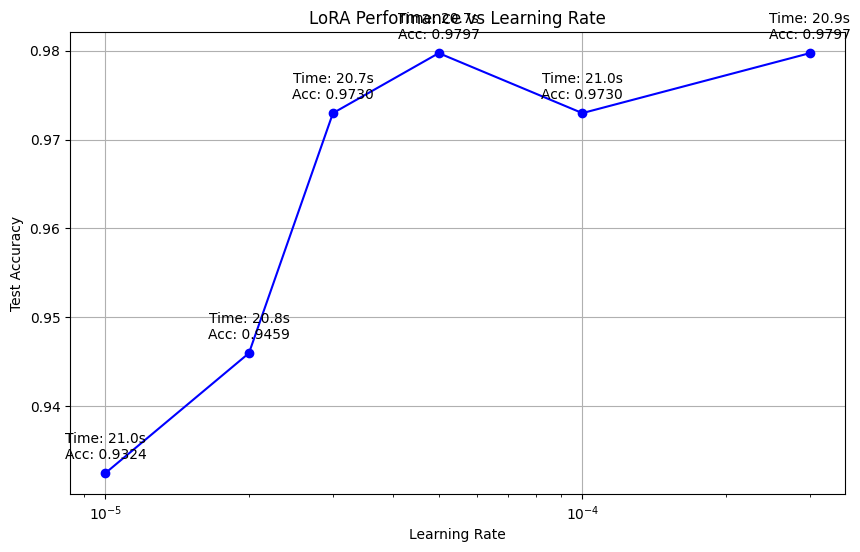

In [15]:
hyperparameter_tuning("LoRA")

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_lora = setup_lora_model(MODEL_NAME)

train_and_profile(model_lora, tokenizer, "LoRA")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- LoRA - Trainable Parameters ---
Trainable: 739586 | All: 44845060 | % Trained: 1.65

--- LoRA ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.54it/s]


Epoch 1 | Training Time: 3.87 s | Train Loss: 0.4112 | Val Loss: 0.2170 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.72it/s]


Epoch 2 | Training Time: 3.90 s | Train Loss: 0.2464 | Val Loss: 0.1757 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.65it/s]


Epoch 3 | Training Time: 3.92 s | Train Loss: 0.2141 | Val Loss: 0.1606 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.43it/s]


Epoch 4 | Training Time: 3.93 s | Train Loss: 0.1824 | Val Loss: 0.1453 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Epoch 5 | Training Time: 3.98 s | Train Loss: 0.1567 | Val Loss: 0.1291 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.97it/s]


--- LoRA ---
Training time: 20.91 seconds
Test Loss: 0.1194 | Test Accuracy: 0.9527


{'train_losses': [0.4111965914835801,
  0.24643529186377655,
  0.21414602104876493,
  0.18243852620189255,
  0.15674176671215007],
 'val_losses': [0.21698095202445983,
  0.17568814009428024,
  0.1606312483549118,
  0.1452757626771927,
  0.12906061559915544],
 'val_accuracies': [0.9527027027027027,
  0.9527027027027027,
  0.9527027027027027,
  0.9527027027027027,
  0.9594594594594594],
 'training_time': 20.91,
 'test_accuracy': 0.9527027027027027}

## ChemBeRTa With AdaLoRA Fine-Tuning

In [18]:
def setup_adalora_model(model_name):
    """
    Set up a model with AdaLoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    ADA_TOTALSTEP = EPOCHS * len(train_dataloader)

    peft_config = AdaLoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        total_step = ADA_TOTALSTEP
    )

    model = get_peft_model(model, peft_config)
    return model


--- AdaLoRA with learning_rate=1e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_1e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51

--- AdaLoRA_lr_1e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]


Epoch 1 | Training Time: 5.90 s | Train Loss: 0.4982 | Val Loss: 0.3161 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


Epoch 2 | Training Time: 5.93 s | Train Loss: 0.3182 | Val Loss: 0.2207 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.23it/s]


Epoch 3 | Training Time: 5.93 s | Train Loss: 0.2603 | Val Loss: 0.1904 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Epoch 4 | Training Time: 5.92 s | Train Loss: 0.2352 | Val Loss: 0.1768 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.38it/s]


Epoch 5 | Training Time: 5.92 s | Train Loss: 0.2221 | Val Loss: 0.1686 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.54it/s]



--- AdaLoRA_lr_1e-05 ---
Training time: 31.26 seconds
Test Loss: 0.1779 | Test Accuracy: 0.9392

--- AdaLoRA with learning_rate=2e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_2e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51

--- AdaLoRA_lr_2e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.66it/s]


Epoch 1 | Training Time: 5.88 s | Train Loss: 0.4169 | Val Loss: 0.2224 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.74it/s]


Epoch 2 | Training Time: 5.90 s | Train Loss: 0.2514 | Val Loss: 0.1791 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.42it/s]


Epoch 3 | Training Time: 5.85 s | Train Loss: 0.2199 | Val Loss: 0.1653 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.72it/s]


Epoch 4 | Training Time: 5.86 s | Train Loss: 0.2020 | Val Loss: 0.1554 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


Epoch 5 | Training Time: 5.87 s | Train Loss: 0.1836 | Val Loss: 0.1475 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s]



--- AdaLoRA_lr_2e-05 ---
Training time: 30.98 seconds
Test Loss: 0.1393 | Test Accuracy: 0.9527

--- AdaLoRA with learning_rate=3e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_3e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51

--- AdaLoRA_lr_3e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.63it/s]


Epoch 1 | Training Time: 5.86 s | Train Loss: 0.3742 | Val Loss: 0.1848 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]


Epoch 2 | Training Time: 5.88 s | Train Loss: 0.2295 | Val Loss: 0.1626 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.39it/s]


Epoch 3 | Training Time: 5.90 s | Train Loss: 0.1938 | Val Loss: 0.1500 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Epoch 4 | Training Time: 5.91 s | Train Loss: 0.1690 | Val Loss: 0.1407 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Epoch 5 | Training Time: 5.92 s | Train Loss: 0.1582 | Val Loss: 0.1333 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.81it/s]



--- AdaLoRA_lr_3e-05 ---
Training time: 31.12 seconds
Test Loss: 0.1205 | Test Accuracy: 0.9459

--- AdaLoRA with learning_rate=5e-05 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_5e-05 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51

--- AdaLoRA_lr_5e-05 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.48it/s]


Epoch 1 | Training Time: 5.91 s | Train Loss: 0.2916 | Val Loss: 0.1632 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Epoch 2 | Training Time: 5.93 s | Train Loss: 0.1858 | Val Loss: 0.1435 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


Epoch 3 | Training Time: 5.91 s | Train Loss: 0.1578 | Val Loss: 0.1325 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


Epoch 4 | Training Time: 5.91 s | Train Loss: 0.1385 | Val Loss: 0.1233 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Epoch 5 | Training Time: 5.91 s | Train Loss: 0.1263 | Val Loss: 0.1171 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.77it/s]



--- AdaLoRA_lr_5e-05 ---
Training time: 31.21 seconds
Test Loss: 0.1011 | Test Accuracy: 0.9527

--- AdaLoRA with learning_rate=0.0001 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_0.0001 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51

--- AdaLoRA_lr_0.0001 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s]


Epoch 1 | Training Time: 5.88 s | Train Loss: 0.2770 | Val Loss: 0.1486 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Epoch 2 | Training Time: 5.91 s | Train Loss: 0.1589 | Val Loss: 0.1310 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


Epoch 3 | Training Time: 5.91 s | Train Loss: 0.1330 | Val Loss: 0.1197 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Epoch 4 | Training Time: 5.92 s | Train Loss: 0.1174 | Val Loss: 0.1050 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


Epoch 5 | Training Time: 5.92 s | Train Loss: 0.0958 | Val Loss: 0.0964 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.74it/s]



--- AdaLoRA_lr_0.0001 ---
Training time: 31.17 seconds
Test Loss: 0.0851 | Test Accuracy: 0.9662

--- AdaLoRA with learning_rate=0.0003 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA_lr_0.0003 - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51

--- AdaLoRA_lr_0.0003 ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.62it/s]


Epoch 1 | Training Time: 5.90 s | Train Loss: 0.1947 | Val Loss: 0.1220 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]


Epoch 2 | Training Time: 5.91 s | Train Loss: 0.1136 | Val Loss: 0.0964 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.44it/s]


Epoch 3 | Training Time: 5.92 s | Train Loss: 0.0822 | Val Loss: 0.1035 | Val Accuracy: 0.9459


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.64it/s]


Epoch 4 | Training Time: 5.91 s | Train Loss: 0.0595 | Val Loss: 0.0826 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.53it/s]


Epoch 5 | Training Time: 5.93 s | Train Loss: 0.0480 | Val Loss: 0.0763 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.65it/s]



--- AdaLoRA_lr_0.0003 ---
Training time: 31.22 seconds
Test Loss: 0.0595 | Test Accuracy: 0.9865


,learning_rate,test_accuracy,training_time
0,0.00001,0.939189,31.26
1,0.00002,0.952703,30.98
2,0.00003,0.945946,31.12
3,0.00005,0.952703,31.21
4,0.00010,0.966216,31.17
5,0.00030,0.986486,31.22


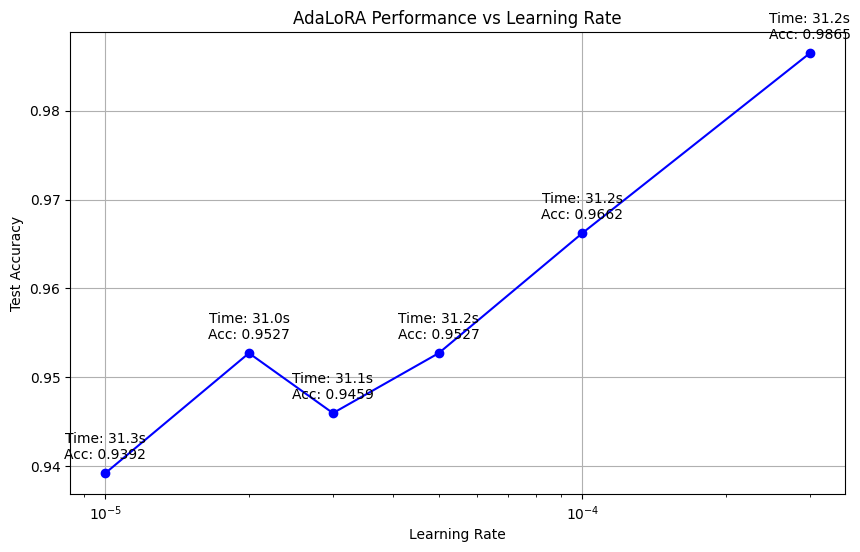

In [19]:
hyperparameter_tuning("AdaLoRA")

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_adalora = setup_adalora_model(MODEL_NAME)

train_and_profile(model_adalora, tokenizer, "AdaLoRA")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- AdaLoRA - Trainable Parameters ---
Trainable: 1606335 | All: 45730290 | % Trained: 3.51

--- AdaLoRA ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.60it/s]


Epoch 1 | Training Time: 5.89 s | Train Loss: 0.3998 | Val Loss: 0.2113 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.42it/s]


Epoch 2 | Training Time: 5.90 s | Train Loss: 0.2441 | Val Loss: 0.1740 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.50it/s]


Epoch 3 | Training Time: 5.93 s | Train Loss: 0.2146 | Val Loss: 0.1623 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Epoch 4 | Training Time: 5.92 s | Train Loss: 0.1929 | Val Loss: 0.1530 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.50it/s]


Epoch 5 | Training Time: 5.93 s | Train Loss: 0.1779 | Val Loss: 0.1457 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 15.79it/s]


--- AdaLoRA ---
Training time: 31.21 seconds
Test Loss: 0.1350 | Test Accuracy: 0.9527


{'train_losses': [0.39984103594277354,
  0.24407740581679988,
  0.2145815787685884,
  0.19292000600615064,
  0.17790752709717364],
 'val_losses': [0.21131958663463593,
  0.17398117631673812,
  0.16226963847875595,
  0.1530315861105919,
  0.14566112756729127],
 'val_accuracies': [0.9527027027027027,
  0.9527027027027027,
  0.9527027027027027,
  0.9527027027027027,
  0.9527027027027027],
 'training_time': 31.21,
 'test_accuracy': 0.9527027027027027}